In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confuse', 'stuck', 'puzzle'],
    'Expectation' : ['expect', 'hope', 'anticipate', 'assume', 'suppose'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor', 'suggest'] # 'like better', 'go for'
}

In [5]:
with open("speech/15.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

[' Hmm.', 'OK, I I see that there is there.', "Is this information on the orange in the orange box asking if I'm traveling to Slovak Republic.", "It's somehow.", 'Well I can.', 'It it it draws, uh, draws my attention because of the color.', 'I can see that I can.', 'I can click.', 'The button, the button, and it will probably.', 'Go to another website.', 'Hmm OK.', 'There are some statistics about the coronavirus cases in Slovakia.', 'Umm?', 'I mean formation about.', 'Vaccination.', 'Some declarations if if you are from abroad.', 'Links which.', 'Ohh which maybe I would like to.', "You'll click if I will be traveling there or leaving there.", 'And would like to gain some more information.', 'Umm?', 'Hey, I see some.', 'Some.', 'Really frequently asked questions with answers.', "I hear it's something in in Slovak, so I'm I'm not sure what does it mean.", 'Hey.', 'The registration to vaccination registration for test.', "I guess it's.", 'All in all, pretty simple and understandable.', '

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

[' Hmm', 'OK I I see that there is there', 'Is this information on the orange in the orange box asking if I am traveling to Slovak Republic', 'it has it is somehow', 'Well I can', 'It it it draws uh draws my attention because of the color', 'I can see that I can', 'I can click', 'The button the button and it will probably', 'Go to another website', 'Hmm OK', 'There are some statistics about the coronavirus cases in Slovakia', 'Umm', 'I mean formation about', 'Vaccination', 'Some declarations if if you are from abroad', 'Links which', 'Ohh which maybe I would like to', 'you shall you will click if I will be traveling there or leaving there', 'And would like to gain some more information', 'Umm', 'Hey I see some', 'Some', 'Really frequently asked questions with answers', 'I hear it has it is something in in Slovak so I am I am not sure what does it mean', 'Hey', 'The registration to vaccination registration for test', 'I guess its', 'All in all pretty simple and understandable', 'Maybe e

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('Hmm', 'n')], [('OK', None), ('I', None), ('I', None), ('see', 'v'), ('that', None), ('there', None), ('is', 'v'), ('there', None)], [('Is', 'v'), ('this', None), ('information', 'n'), ('on', None), ('the', None), ('orange', 'n'), ('in', None), ('the', None), ('orange', 'n'), ('box', 'n'), ('asking', 'v'), ('if', None), ('I', None), ('am', 'v'), ('traveling', 'v'), ('to', None), ('Slovak', 'n'), ('Republic', 'n')], [('it', None), ('has', 'v'), ('it', None), ('is', 'v'), ('somehow', 'r')], [('Well', 'r'), ('I', None), ('can', None)], [('It', None), ('it', None), ('it', None), ('draws', 'v'), ('uh', 'a'), ('draws', 'n'), ('my', None), ('attention', 'n'), ('because', None), ('of', None), ('the', None), ('color', 'n')], [('I', None), ('can', None), ('see', 'v'), ('that', None), ('I', None), ('can', None)], [('I', None), ('can', None), ('click', 'v')], [('The', None), ('button', 'n'), ('the', None), ('button', 'n'), ('and', None), ('it', None), ('will', None), ('probably', 'r')], [('Go',

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            if word.lower() == "like":
                lemmatized_sentence.append(word + '-(NON-STANDARD)')
            else:
                lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['Hmm'], ['OK', 'I', 'I', 'see', 'that', 'there', 'be', 'there'], ['Is', 'this', 'information', 'on', 'the', 'orange', 'in', 'the', 'orange', 'box', 'ask', 'if', 'I', 'be', 'travel', 'to', 'Slovak', 'Republic'], ['it', 'have', 'it', 'be', 'somehow'], ['Well', 'I', 'can'], ['It', 'it', 'it', 'draw', 'uh', 'draw', 'my', 'attention', 'because', 'of', 'the', 'color'], ['I', 'can', 'see', 'that', 'I', 'can'], ['I', 'can', 'click'], ['The', 'button', 'the', 'button', 'and', 'it', 'will', 'probably'], ['Go', 'to', 'another', 'website'], ['Hmm', 'OK'], ['There', 'be', 'some', 'statistic', 'about', 'the', 'coronavirus', 'case', 'in', 'Slovakia'], ['Umm'], ['I', 'mean', 'formation', 'about'], ['Vaccination'], ['Some', 'declaration', 'if', 'if', 'you', 'be', 'from', 'abroad'], ['Links', 'which'], ['Ohh', 'which', 'maybe', 'I', 'would', 'like', 'to'], ['you', 'shall', 'you', 'will', 'click', 'if', 'I', 'will', 'be', 'travel', 'there', 'or', 'leave', 'there'], ['And', 'would', 'like', 'to', 'gain'

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['hmm'], ['ok', 'see'], ['information', 'orange', 'orange', 'box', 'ask', 'travel', 'slovak', 'republic'], ['somehow'], ['well'], ['draw', 'uh', 'draw', 'attention', 'color'], ['see'], ['click'], ['button', 'button', 'probably'], ['go', 'another', 'website'], ['hmm', 'ok'], ['statistic', 'coronavirus', 'case', 'slovakia'], ['umm'], ['mean', 'formation'], ['vaccination'], ['declaration', 'abroad'], ['links'], ['ohh', 'maybe', 'would', 'like'], ['shall', 'click', 'travel', 'leave'], ['would', 'like', 'gain', 'information'], ['umm'], ['hey', 'see'], [], ['really', 'frequently', 'ask', 'question', 'answer'], ['hear', 'something', 'slovak', 'not', 'sure', 'mean'], ['hey'], ['registration', 'vaccination', 'registration', 'test'], ['guess'], ['pretty', 'simple', 'understandable'], ['maybe', 'except', 'short', 'information', 'slovak'], ['everything', 'visible', 'big', 'font', 'read', 'everything', 'easily'], ['also'], ['also', 'click', 'easily', 'thing'], ['no', 'popup', 'ad', 'sometimes'], [

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
    'know': 2.0, 
    'understand': 2.0,
    'kind': 1.5,
    'pretty': 1.5,
    'inconsistent': -2.0
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word == v:
                    cat_list.append(k)
                    #return k
    if cat_list:
        return cat_list
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)

    sent_cat = search(sentiment_category, line)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv("results/15-results.csv")

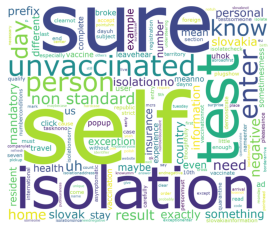

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

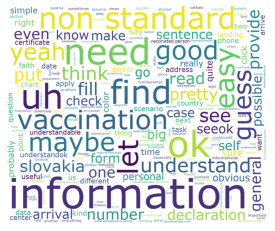

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,Hmm.,hmm,0.000000,0.0,0.0,1.0,0.0000,Neutral,None
1,"OK, I I see that there is there.",ok see,0.500000,1.0,0.0,0.0,0.6369,Positive,None
2,Is this information on the orange in the orang...,information orange orange box ask travel slova...,0.000000,0.0,0.0,1.0,0.0000,Neutral,None
3,It's somehow.,somehow,0.000000,0.0,0.0,1.0,0.0000,Neutral,None
4,Well I can.,well,0.000000,1.0,0.0,0.0,0.2732,Positive,None
...,...,...,...,...,...,...,...,...,...
500,Maybe it's just my overthinking so so we can.,maybe overthinking,0.000000,0.0,0.0,1.0,0.0000,Neutral,None
501,Maybe that's it.,maybe,0.000000,0.0,0.0,1.0,0.0000,Neutral,None
502,But still I I think I'm putting 4 in this one ...,still think put 4 one particular reason,0.333333,0.0,0.0,1.0,0.0000,Neutral,None
503,"OK, thank you.",ok thank,0.500000,1.0,0.0,0.0,0.5719,Positive,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

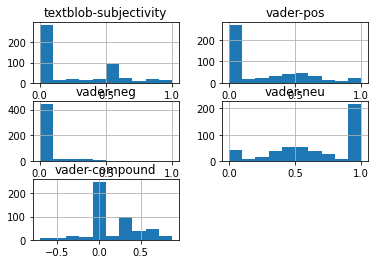

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

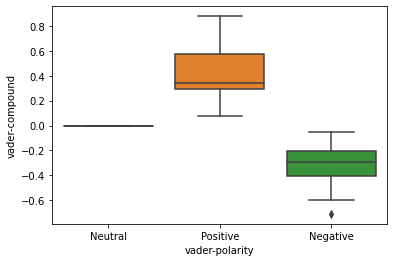

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

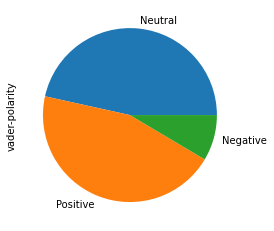

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
276,"After the negative P MCRS test, you will be or...",negative p mcrs test order no early 5th day ar...,0.350000,0.000,0.396,0.604,-0.7096,Negative,None
275,Since I I've marked that I am no exception to ...,since mark no exception home isolation end,0.000000,0.000,0.495,0.505,-0.5994,Negative,None
232,Conditions for entry to Slovakia are strict an...,conditions entry slovakia strict negative test...,0.411111,0.144,0.256,0.600,-0.5859,Negative,None
120,"Show the the negative, uh, results of tests.",show negative uh result test,0.400000,0.000,0.481,0.519,-0.5719,Negative,None
344,The negative test results and from some countr...,negative test result country not,0.400000,0.000,0.481,0.519,-0.5719,Negative,None
249,They must demonstrate the negative test result...,must demonstrate negative test result seven day,0.400000,0.000,0.381,0.619,-0.5719,Negative,None
79,"Uh, if, uh, if a person is vaccinated, they do...",uh uh person vaccinate not need enter mandator...,0.000000,0.000,0.329,0.671,-0.4445,Negative,None
402,"In, in each case it's it's different name and ...",case different name code like-(non-standard) n...,0.744444,0.000,0.296,0.704,-0.4168,Negative,None
282,Let's say I don't have a health insurance in t...,let us say not health insurance eu resident un...,0.000000,0.000,0.213,0.787,-0.4019,Negative,None
272,After entering Slovakia it is necessary to sta...,enter slovakia necessary stay home isolation,1.000000,0.000,0.351,0.649,-0.4019,Negative,None


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
297,"In case of a positive test, in order to protec...",case positive test order protect loved one hyg...,0.672727,0.558,0.000,0.442,0.8779,Positive,None
483,"Found their different color used if needed, so...",found different color use need guess know easy...,0.608333,0.407,0.076,0.517,0.8625,Positive,None
95,When I was traveling during during pandemic ti...,travel pandemic time not always self explanato...,0.515873,0.524,0.000,0.476,0.8360,Positive,[Satisfaction]
93,The sentence is put in in a pretty easy way to...,sentence put pretty easy way understand mean look,0.840278,0.708,0.000,0.292,0.8271,Positive,None
61,New cases were registered in each region today...,new case register region today yeah would say ...,0.643939,0.520,0.000,0.480,0.8258,Positive,None
89,"Uh, it's in bold and in the fund is in other c...",uh bold fund color easy find think also,0.750000,0.630,0.000,0.370,0.8176,Positive,None
410,"OK, so it's it's also pretty easy to understan...",ok also pretty easy understand one two state i...,0.777778,0.486,0.101,0.413,0.8126,Positive,None
359,"Hey, uh, print out the following good five dec...",hey uh print follow good five declaration give...,0.675000,0.477,0.000,0.523,0.8020,Positive,None
36,"Oh yeah, I have a. I hope I have a good experi...",oh yeah hope good experience,0.600000,0.800,0.000,0.200,0.7906,Positive,[Expectation]
166,"To the best of your ability, you are planning ...",best ability plan arrive plane usa landing vie...,0.300000,0.419,0.000,0.581,0.7579,Positive,None
